In [1]:
import numpy as np                                     # Matlab like syntax for linear algebra and functions
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
import seaborn as sns       
import pandas as pd                           # Make the plots nicer to look at
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
import sys                                             # Modules to see files and folders in directories
from scipy import stats
from iminuit.cost import LeastSquares
from scipy import optimize
from scipy.stats import kstest
from scipy.stats import poisson
from scipy.stats import binom
from scipy.stats import t

sys.path.append('../External_Functions')
from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH
from ExternalFunctions import nice_string_output, add_text_to_ax    # Useful functions to print fit results on figure


plt.rcParams['font.size'] = 18     # Set some basic plotting parameters

# STANDARD PDF'S

In [2]:
def gauss(x,mu,sigma):
	return 1/(sigma*2*np.pi)*np.exp(-(x-mu)**2/(2*sigma**2))

def poisson(r,lamb):
	return stats.poisson.pmf(r,lamb)

def binomial(r,n,p):
	return stats.binom.pmf(r,n,p)

def student_t(x,fp):
	return stats.t.pdf(x,fp) #fp = freedom parameter


# Transformation method for producing random numbers

Check if function can be inverted with wolfram alpha

if == true:
	Then you can use tranformation method and you should adress it, but still use accept reject

else:
	Transformation is not possible and you should adress it, then use accept reject

# Accept reject method for producing random numbers


Integral of f(x) = x, x in [0, 1] is: 	  1.0041 +- 0.0053
The efficiency of the Accept/Reject method used here is: 	 71.72% +/- 0.38%


0.9505381238092354

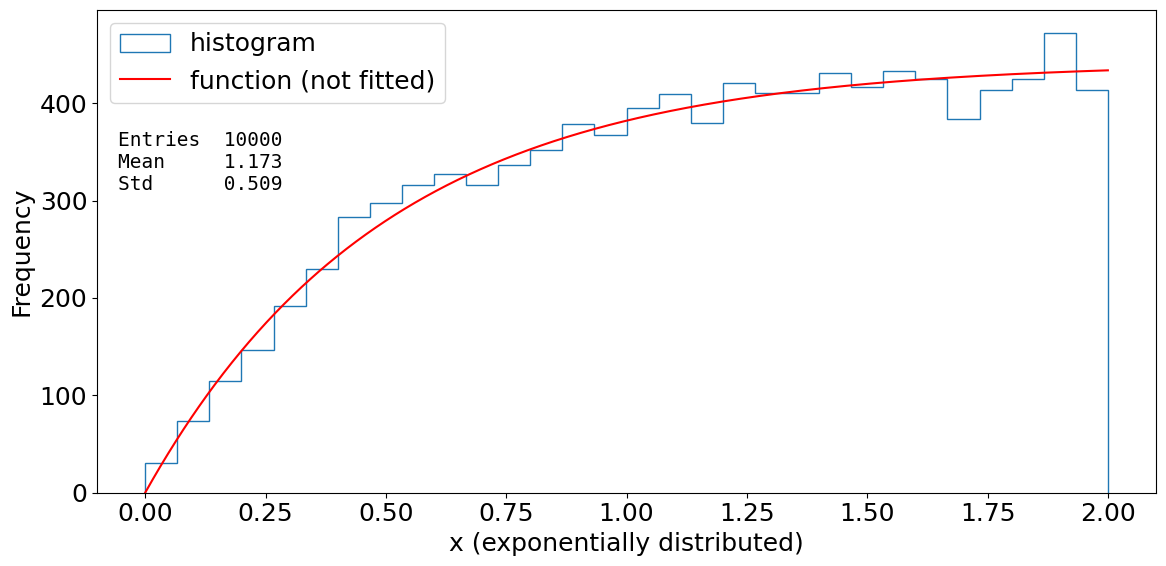

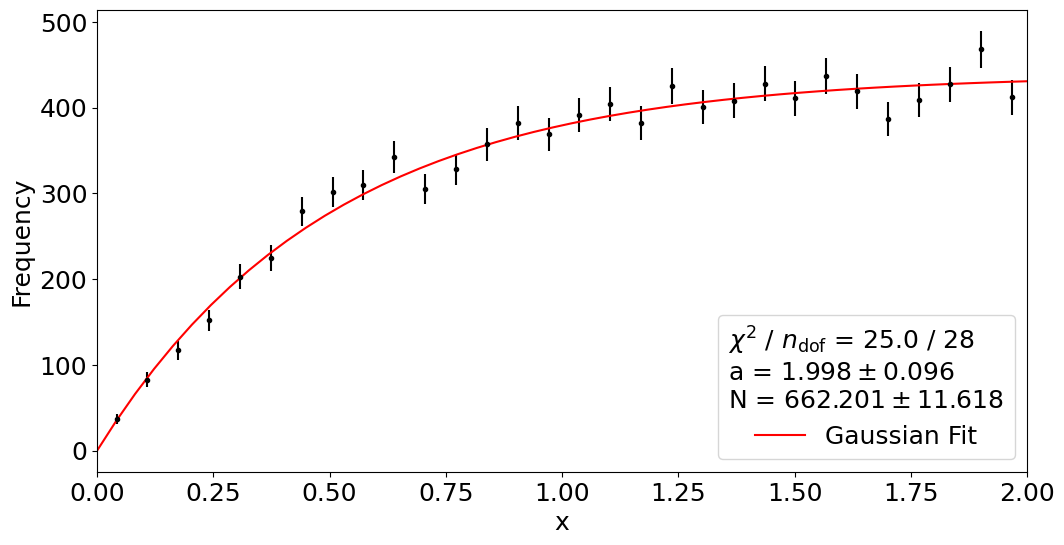

In [3]:
r = np.random
r.seed(42)

save_plots = False   
N_points = 10000      # Number of random points to be produced!

xmin = 0.0
xmax = 2.0
N_bins = 30

def fx_2x(x) :
    # Normalization is N_points * binwidth:
    k = (xmax - xmin) / N_bins
    N = N_points * k
    return N*0.66262*(1-np.exp(-2*x))

N_try = 0
ymin = 0.0      # Minimum value the function will take!
ymax = 0.7      # Maximum value the function will take!
x_accepted = np.zeros(N_points)

for i in range(N_points):
    
    while True:
        
        # Count the number of tries, to get efficiency/integral
        N_try += 1                    
        
        # Range that f(x) is defined/wanted in:
        x_test = r.uniform(xmin, xmax)  
        
        # Upper bound for function values:
        y_test = r.uniform(ymin, ymax)
        
        if (y_test < 0.66262*(1-np.exp(-2*x_test))):
            break
            
    x_accepted[i] = x_test

# Efficiency
eff = N_points / N_try                        

# Error on efficiency (binomial!)
eff_error = np.sqrt(eff * (1-eff) / N_try) 

# Integral
integral =  eff * (xmax-xmin) * (ymax-ymin)

# Error on integral
eintegral = eff_error * (xmax-xmin) * (ymax-ymin)  

print(f"\nIntegral of f(x) = x, x in [0, 1] is: \t {integral:7.4f} +- {eintegral:6.4f}")
print(f"The efficiency of the Accept/Reject method used here is: \t {eff:.2%} +/- {eff_error:.2%}")
# We normalized the function ahead of time, so we should hope to get a result consistent with unity!

fig2, ax2 = plt.subplots(figsize=(12, 6))
ax2.hist(x_accepted, bins=N_bins, range=(xmin, xmax), histtype='step', label='histogram' )
ax2.set(xlabel="x (exponentially distributed)", ylabel="Frequency", xlim=(xmin-0.1, xmax+0.1));

# Plot f(x)
x_axis2 = np.linspace(xmin, xmax, 1000)
y_axis2 = fx_2x(x_axis2)
ax2.plot(x_axis2, y_axis2, 'r-', label='function (not fitted)')

# Define the figure text
d2 = {'Entries': len(x_accepted),
      'Mean': x_accepted.mean(),
      'Std': x_accepted.std(ddof=1),
    }

# Add figure text
text2 = nice_string_output(d2, extra_spacing=2, decimals=3)
add_text_to_ax(0.02, 0.75, text2, ax2, fontsize=14)

# Add legend
ax2.legend(loc='best')
fig2.tight_layout()

# Save figure
if save_plots: 
    fig2.savefig("Hist_2x_AcceptRejectMethod.pdf", dpi=600)
    
# Show the figure
fig2

def gauss_fit(x,a,N):
    return  N*(0.66262*(1-np.exp(-a*x)))

# Find the x, y and error on y (sy) given the histogram:
counts, bin_edges = np.histogram(x_accepted, bins=N_bins)
x = (bin_edges[1:] + bin_edges[:-1])/2
y = counts
sy = np.sqrt(counts)
x = x[y>0]
sy = sy[y>0]
y = y[y>0]

chi2fit = Chi2Regression(gauss_fit, x, y, sy)
# NOTE: Did you remember to ensure, that all bins had entries in them, i.e. that y>0?

minuit_chi2 = Minuit(chi2fit,a=2, N=20)
minuit_chi2.errordef = 1.0     # This is the definition for ChiSqaure fits

chi2_value = minuit_chi2.fval
N_NotEmptyBin = np.sum(y>0)
Ndof_value = N_NotEmptyBin - len(minuit_chi2.parameters)

minuit_chi2.migrad()


fit_info = [f"$\\chi^2$ / $n_\\mathrm{{dof}}$ = {minuit_chi2.fval:.1f} / {len(x) - minuit_chi2.nfit}"]
for p, v, e in zip(minuit_chi2.parameters, minuit_chi2.values, minuit_chi2.errors):
	fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")


fig, ax = plt.subplots(figsize=(12, 6))
ax.errorbar(x,y,sy,fmt ='.', color = 'Black')
ax.plot(np.linspace(0,2), gauss_fit(np.linspace(0,2),*minuit_chi2.values),label = 'Gaussian Fit', color = 'Red')
ax.set_xlim(0,2)
ax.set(xlabel="x", ylabel="Frequency");
ax.legend(title="\n".join(fit_info));

stats.chi2.sf(16.9,Ndof_value)

# Statistical Test's

In [4]:
def one_sample_test(x,mu,sigma_x):
	z = (x-mu)/(sigma_x)
	return z

def two_sample_test(x1,x2,sigma_x1,sigma_x2):
	z = (x1-x2)/(np.sqrt(sigma_x1**2+sigma_x2**2))
	return z

def chis2_test(obs,exp,sigma):
	return np.sum(((obs-exp)/sigma)**2)

def kolmogorov(x,y):
	return kstest(x,y)

def ww_runs(pos,neg,tot):

	mu = 2*pos*neg/tot + 1

	var = 2*pos*neg*(2*pos*neg-tot)/(tot**2*(tot-1))

	return mu, np.sqrt(var)

def fisher_exact(table,t):
	return stats.fisher_exact(table, alternative=t) #t must be a string ex. 'two-sided' or 'greater' or 'less'

In [5]:
table = np.array([[6,2],
	[1,4]])
fisher_exact(table,'less')

(12.0, 0.9953379953379954)

# FISHER TEST

In [6]:
def fisher(a,b):
		#From the plots we can see that separating the data according the the A and B category with a fisher projection can work.
	#F = w0 + w•x
	#w = sum(covariance matrix healthy and covariance matrix sick)^-1*(meanhealthy-meansick)
	s_cov_AB = np.mean(b*a)-np.mean(b)*np.mean(a)
	s_cov_AA = np.mean(a*a)-np.mean(a)*np.mean(a)
	s_cov_BB = np.mean(b*b)-np.mean(b)*np.mean(b)

	h_cov_AB = np.mean(b*a)-np.mean(b)*np.mean(a)
	h_cov_AA = np.mean(a*a)-np.mean(a)*np.mean(a)
	h_cov_BB = np.mean(b*b)-np.mean(b)*np.mean(b)

	#make the matrices with covariance
	M_S = np.array([[s_cov_AA, s_cov_AB],[s_cov_AB, s_cov_BB]])
	H_S = np.array([[h_cov_AA, h_cov_AB],[h_cov_AB, h_cov_BB]])

	#make the mean difference vector
	s_mA = np.mean(a)
	s_mB = np.mean(b)
	h_mA = np.mean(a)
	h_mB = np.mean(b)
	#mean_vector = np.array([s_mA - h_mA, s_mB - h_mB])
	mean_vector = np.array([h_mA - s_mA, h_mB - s_mB])

	matrix_in = np.linalg.inv(M_S+H_S)
	print(f"m_inv {matrix_in.shape}") 
	print(f"mean_vector {mean_vector}")
	weights = matrix_in.dot(mean_vector)
	print(f"weights {weights.shape}")

	data_merge = np.asmatrix([a,b]) #Only sick data
	print(f"data {data_merge.shape}")

	F = np.array(weights.T.dot(data_merge)) 
	F2 = F[0,:] #this is just because the format i got out for F cannot be plotted in a histogram
	print(F2.shape)

	data_merge_h = np.asmatrix([a,b]) #only healthy data
	Fh = np.array(weights.T.dot(data_merge_h))
	F2h = Fh[0,:]

	return F2, F2h